# Курсовой проект

# Построение модели классификации

## 1.Обзор обучающего датасета

Подключение библиотек и скриптов

In [225]:
!pip install xgboost
# !pip install lightgbm
# !pip install catboost

In [6]:
import numpy as np
import pandas as pd

In [216]:
import pickle

In [77]:
from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint

In [224]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

ModuleNotFoundError: No module named 'xgboost'

In [7]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

Пути к директориям и файлам

In [27]:
# input
#TRAIN_DATASET_PATH = 'course_project_train.csv'
#TEST_DATASET_PATH = 'course_project_test.csv'

DATASET_PATH = 'course_project_train.csv'

# output
PREP_DATASET_PATH = 'course_project_train_prev.csv'

### Загрузка данных

Описание базового датасета

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые льготы
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [175]:
df_base = pd.read_csv(DATASET_PATH)
#df = pd.read_csv(PREP_DATASET_PATH)

df = pd.read_csv(DATASET_PATH)

df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [176]:
df.shape

(7500, 17)

In [177]:
df.iloc[0]

Home Ownership                            Own Home
Annual Income                               482087
Years in current job                           NaN
Tax Liens                                        0
Number of Open Accounts                         11
Years of Credit History                       26.3
Maximum Open Credit                         685960
Number of Credit Problems                        1
Months since last delinquent                   NaN
Bankruptcies                                     1
Purpose                         debt consolidation
Term                                    Short Term
Current Loan Amount                          1e+08
Current Credit Balance                       47386
Monthly Debt                                  7914
Credit Score                                   749
Credit Default                                   0
Name: 0, dtype: object

In [178]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    5943 non-null float64
Credit Default                  7

Приведение типов

# ???

### Выделение целевой переменной и групп признаков

In [179]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_base.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = df.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES)

### Обзор распределения

In [180]:
df[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

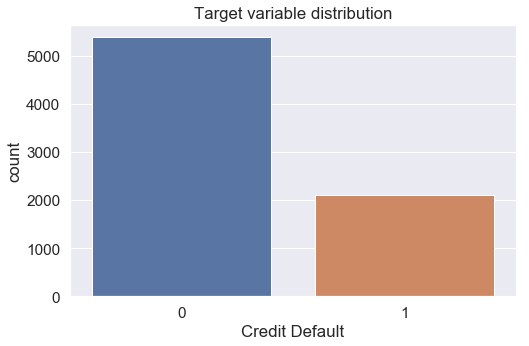

In [181]:
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET_NAME, data=df)

plt.title('Target variable distribution')
plt.show()

числовые переменные ??

In [182]:
df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


 Номинальные??

In [183]:
for col_name in df.select_dtypes(include='object').columns:
    print(str(col_name)+'   \n'+str(df[col_name].value_counts()))

Home Ownership   
Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
Years in current job   
10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
Purpose   
debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64
Term   
Short Term    5556
Long Term     1944
Name: Term, dtype: int64


Корреляция с базовыми признаками

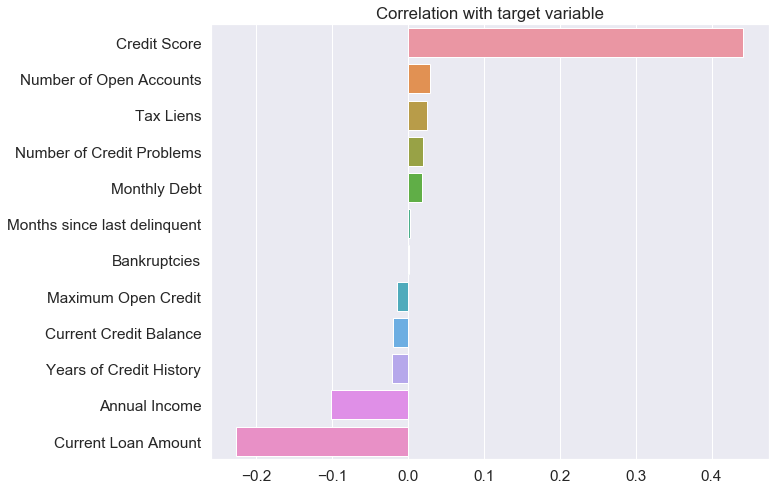

In [184]:
corr_with_target = df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

### Оценка признака с наибольшим влиянием в разрезе целевой переменной

In [185]:
CORRELATION_FEATURE_NAME = "Current Loan Amount"
#CORRELATION_FEATURE_NAME = "Credit Score"
#CORRELATION_FEATURE_NAME = "Bankruptcies"

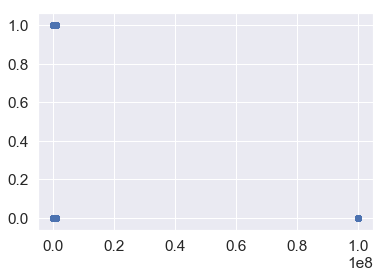

In [186]:
plt.scatter(df[CORRELATION_FEATURE_NAME],df[TARGET_NAME])

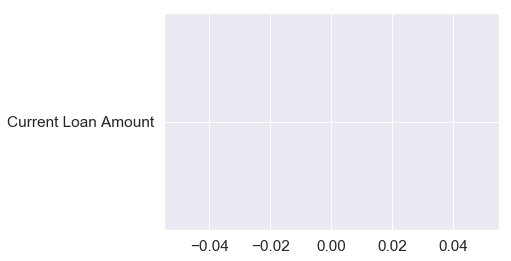

In [187]:
plt.plot(CORRELATION_FEATURE_NAME)

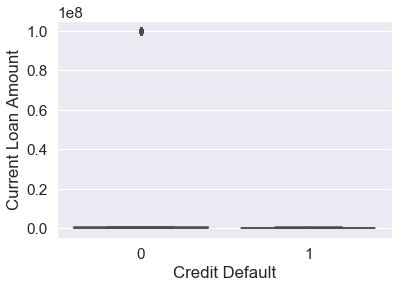

In [188]:
sns.boxplot(x=df[TARGET_NAME],y=df[CORRELATION_FEATURE_NAME])

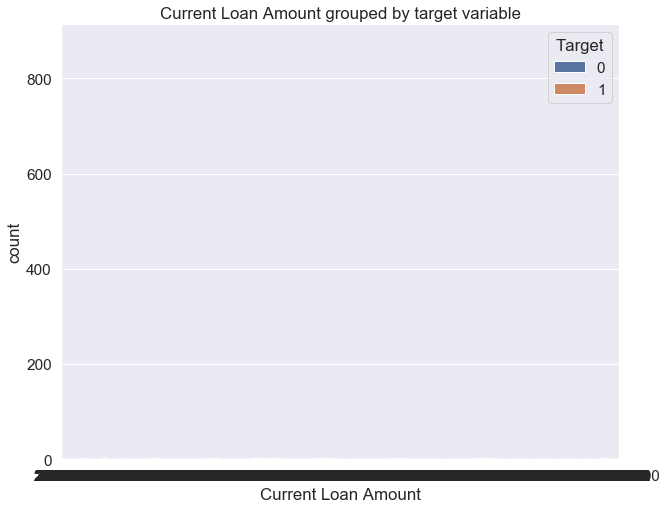

In [189]:
plt.figure(figsize=(10, 8))

sns.countplot(x=CORRELATION_FEATURE_NAME, hue=TARGET_NAME, data=df)
plt.title(CORRELATION_FEATURE_NAME+' grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

In [190]:
df[CORRELATION_FEATURE_NAME].fillna(0).astype(np.int64)

0       99999999
1         264968
2       99999999
3         121396
4         125840
5         337304
6       99999999
7         250888
8         129734
9         572880
10        220858
11        441100
12        337766
13        549780
14        185262
15        145134
16        313038
17        498872
18        553586
19        309672
20        585090
21        324852
22      99999999
23        174878
24        467676
25        108042
26         66110
27      99999999
28        155782
29        357918
          ...   
7470       66352
7471      526570
7472      539902
7473       87516
7474      376618
7475    99999999
7476      324104
7477      528000
7478      787864
7479      105490
7480      432520
7481      559790
7482      188430
7483      328526
7484      161436
7485      466796
7486      111760
7487      267982
7488      129338
7489      753764
7490      683650
7491      437404
7492      332948
7493      448052
7494      290400
7495      129360
7496      444048
7497    999999

Сформируем выборку и рассчитаем наблюдаемые частоты

In [191]:
cor_and_target_s = df.loc[df[CORRELATION_FEATURE_NAME].fillna(0).astype(np.int64), ['ID', CORRELATION_FEATURE_NAME, TARGET_NAME]].sample(3000)

KeyError: "None of [Int64Index([99999999,   264968, 99999999,   121396,   125840,   337304,\n            99999999,   250888,   129734,   572880,\n            ...\n              683650,   437404,   332948,   448052,   290400,   129360,\n              444048, 99999999,   615274,    26928],\n           dtype='int64', length=7500)] are in the [index]"

In [ ]:
table = cor_and_target_s.pivot_table(values='ID', index=CORRELATION_FEATURE_NAME, columns=TARGET_NAME, aggfunc='count')
table

In [ ]:
chi2, p, dof, expected = chi2_contingency(table, correction=False)
p

In [192]:
#CORRELATION_FEATURE_NAME = "Current Loan Amount"
CORRELATION_FEATURE_NAME = "Credit Score"
#CORRELATION_FEATURE_NAME = "Bankruptcies"

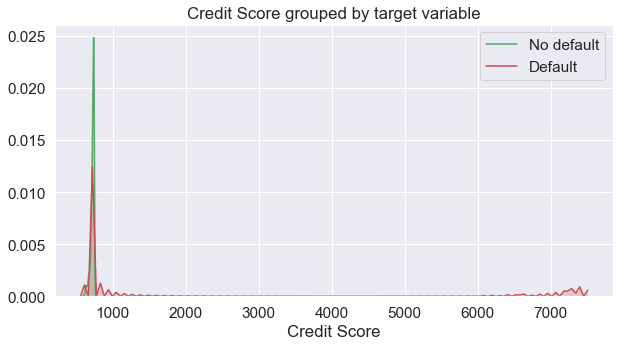

In [193]:
limit_bal_with_target_s = df[[CORRELATION_FEATURE_NAME, TARGET_NAME]].sample(1000)
limit_bal_s = limit_bal_with_target_s[CORRELATION_FEATURE_NAME]
limit_bal_target_0 = limit_bal_s[limit_bal_with_target_s[TARGET_NAME] == 0]
limit_bal_target_1 = limit_bal_s[limit_bal_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(limit_bal_target_0, shade=True, label='No default', color='g')
sns.kdeplot(limit_bal_target_1, shade=True, label='Default', color='r')

plt.xlabel(CORRELATION_FEATURE_NAME)
plt.title(CORRELATION_FEATURE_NAME + ' grouped by target variable')
plt.show()

In [194]:
shapiro(limit_bal_s)

(nan, 1.0)

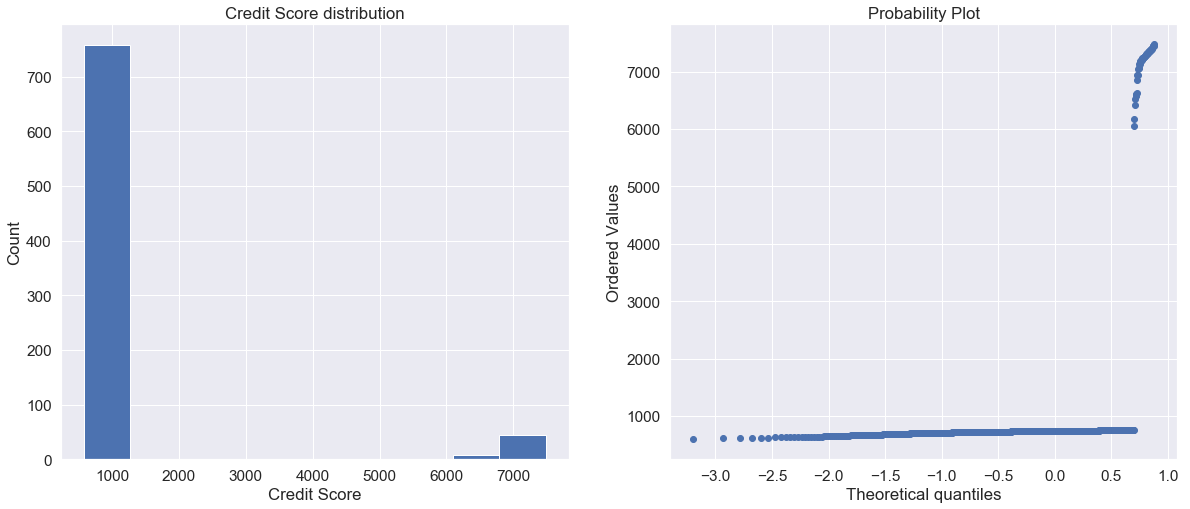

In [195]:
plt.figure(figsize=(20, 8))

ax1 = plt.subplot(121)
ax1.set_xlabel(CORRELATION_FEATURE_NAME)
ax1.set_ylabel('Count')
ax1.set_title(CORRELATION_FEATURE_NAME+' distribution')
limit_bal_s.hist()

plt.subplot(122)
probplot(limit_bal_s, dist='norm', plot=plt)

plt.show()

In [196]:
mannwhitneyu(limit_bal_target_0, limit_bal_target_1)

MannwhitneyuResult(statistic=95682.0, pvalue=0.023069933053840364)

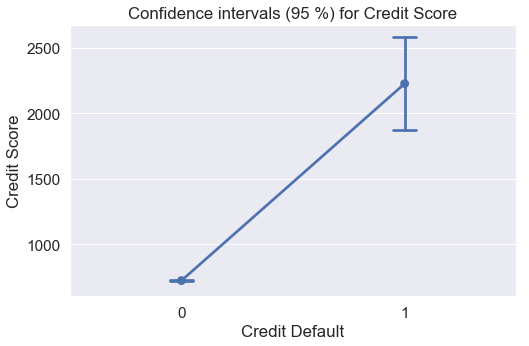

In [197]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y=CORRELATION_FEATURE_NAME, data=limit_bal_with_target_s, capsize=.1)

plt.title('Confidence intervals (95 %) for ' + CORRELATION_FEATURE_NAME)
plt.show()

## 2.Обработка выбросов

## 3.Обработка пропусков

## 4.Анализ данных

### Анализ признакового пространства

Матрица корреляций

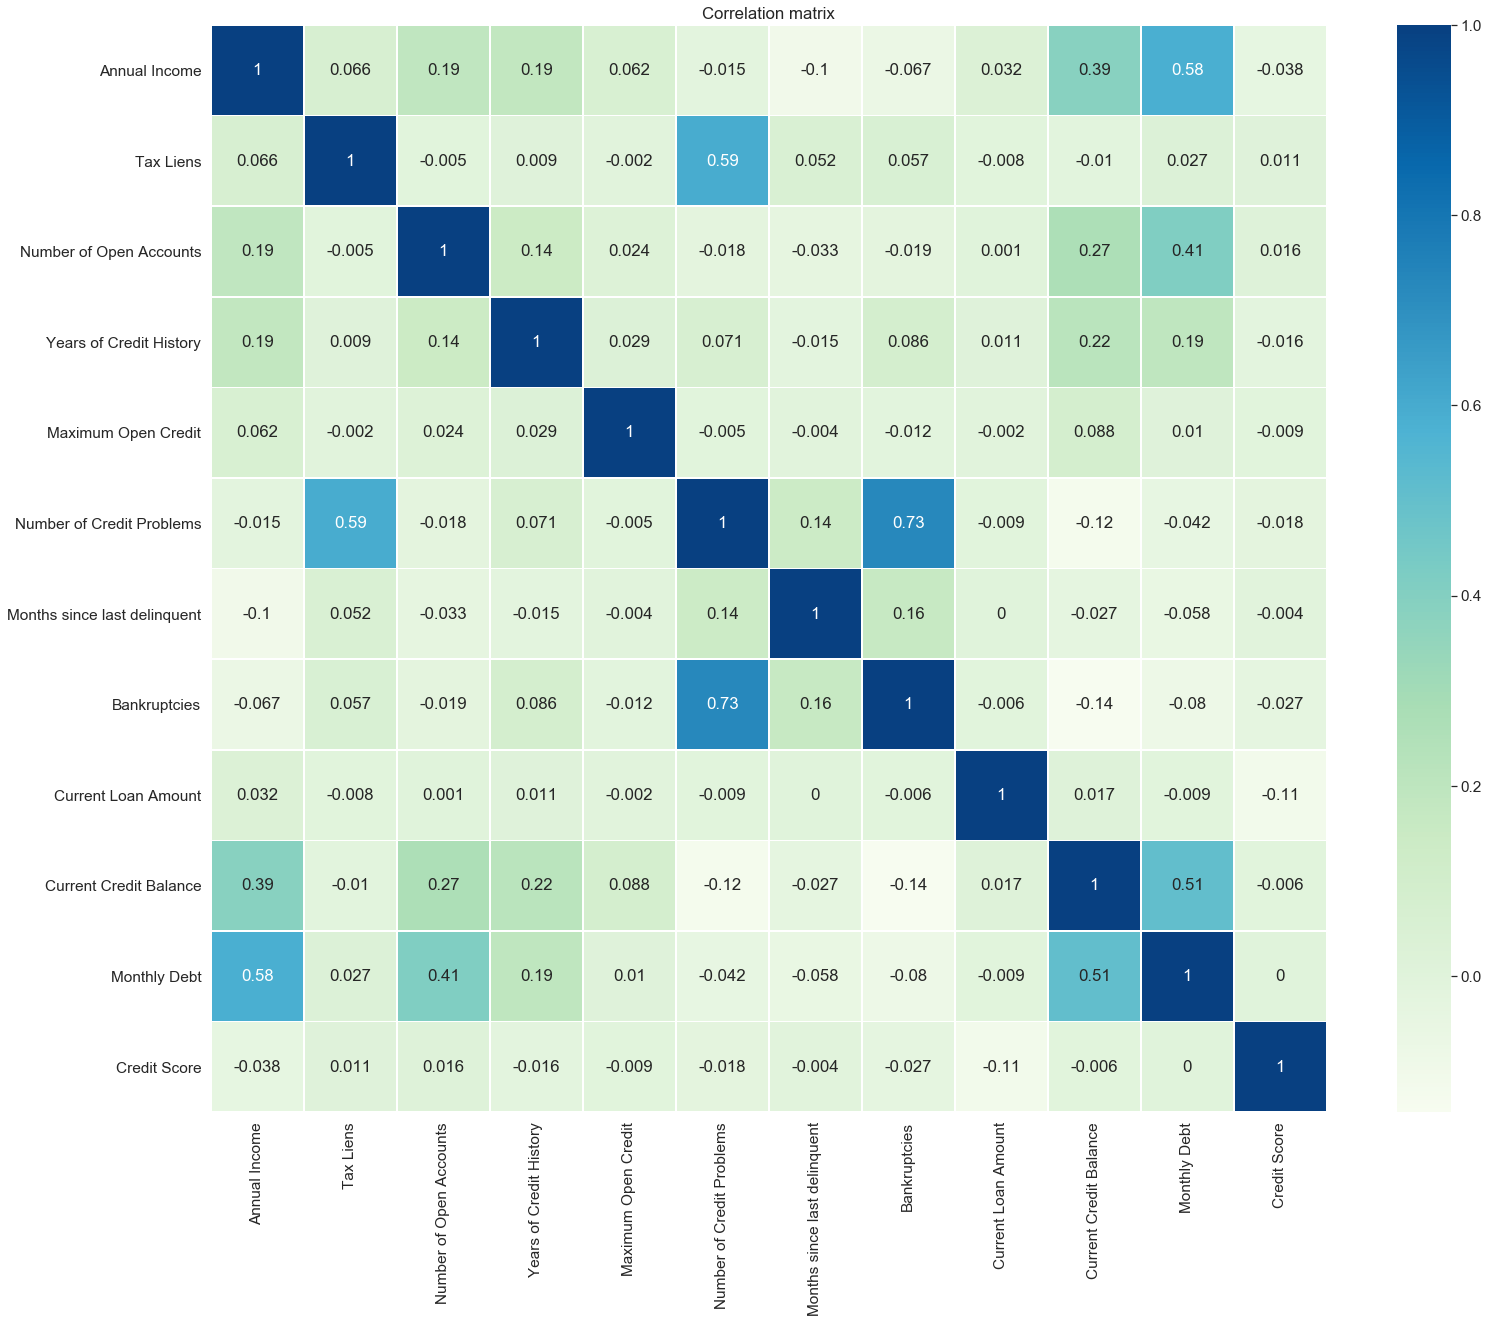

In [198]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)
sns.heatmap(df[BASE_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

Выделение целевой переменной и групп признаков

In [199]:
BASE_FEATURE_NAMES = df_base.columns.drop(TARGET_NAME).tolist()
#NEW_FEATURE_NAMES = df.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES).tolist(b)
NUM_FEATURE_NAMES = df_base.select_dtypes(include=['float64']).columns

In [200]:
????

Object `??` not found.


In [201]:
NEW_FEATURE_NAMES

Index([], dtype='object')

In [202]:
BASE_FEATURE_NAMES

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

### Приведение типов для модели CatBoost

In [203]:
CAT_FEATURE_NAMES=BASE_FEATURE_NAMES

In [204]:
for colname in CAT_FEATURE_NAMES:
    df[colname] = pd.Categorical(df[colname])
    
df[CAT_FEATURE_NAMES].dtypes

Home Ownership                  category
Annual Income                   category
Years in current job            category
Tax Liens                       category
Number of Open Accounts         category
Years of Credit History         category
Maximum Open Credit             category
Number of Credit Problems       category
Months since last delinquent    category
Bankruptcies                    category
Purpose                         category
Term                            category
Current Loan Amount             category
Current Credit Balance          category
Monthly Debt                    category
Credit Score                    category
dtype: object

In [207]:
df_base.info

<bound method DataFrame.info of      Home Ownership  Annual Income Years in current job  Tax Liens  \
0          Own Home       482087.0                  NaN        0.0   
1          Own Home      1025487.0            10+ years        0.0   
2     Home Mortgage       751412.0              8 years        0.0   
3          Own Home       805068.0              6 years        0.0   
4              Rent       776264.0              8 years        0.0   
5              Rent            NaN              7 years        0.0   
6     Home Mortgage      1511108.0            10+ years        0.0   
7              Rent      1040060.0            10+ years        0.0   
8     Home Mortgage            NaN              5 years        0.0   
9     Home Mortgage            NaN               1 year        0.0   
10    Home Mortgage            NaN             < 1 year        0.0   
11    Home Mortgage      1828560.0              4 years        0.0   
12    Home Mortgage       933432.0            10+ years   

### Нормализация данных

In [220]:
scaler = StandardScaler()

df_norm = df.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

df = df_norm.copy()

TypeError: '<' not supported between instances of 'CategoricalDtype' and 'CategoricalDtype'

In [221]:
SCALER_FILE_PATH = 'scaler.pkl'

Сохранение модели для нормализации данных

In [222]:
with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

### Разбиение на train и test

In [ ]:
X = df[SELECTED_FEATURE_NAMES]
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

In [223]:
SELECTED_FEATURE_NAMES

NameError: name 'SELECTED_FEATURE_NAMES' is not defined

## 5.Отбор признаков

## 6.Балансировка классов

## 7.Подбор моделей, получение бейзлана

## 8.Выбор наилучшей модели, настройка гиперпараметров

## 9.Проверка качества, борьба с переобучением

## 10.Интерпретация результатов

# Прогнозирование на тестовом датасете